In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

In [2]:
dataset = pd.read_csv('data.csv')

In [3]:
dataset.head()

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            450000 non-null  object 
 1   order_id              450000 non-null  int64  
 2   order_date            450000 non-null  object 
 3   allot_time            450000 non-null  object 
 4   accept_time           449843 non-null  object 
 5   pickup_time           447579 non-null  object 
 6   delivered_time        444782 non-null  object 
 7   rider_id              450000 non-null  int64  
 8   first_mile_distance   450000 non-null  float64
 9   last_mile_distance    450000 non-null  float64
 10  alloted_orders        433052 non-null  float64
 11  delivered_orders      432659 non-null  float64
 12  cancelled             450000 non-null  int64  
 13  undelivered_orders    432659 non-null  float64
 14  lifetime_order_count  449947 non-null  float64
 15  

In [7]:
dataset.drop(['pickup_time', 'delivered_time','cancelled_time'],axis=1,inplace=True)
dataset.drop_duplicates(inplace=True)

In [8]:
dataset.isna().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                157
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders           16948
delivered_orders         17341
cancelled                    0
undelivered_orders       17341
lifetime_order_count        53
reassignment_method     436256
reassignment_reason     436247
reassigned_order        436247
session_time              3675
dtype: int64

In [9]:
dataset['accept_time_NA'] = np.where(dataset['accept_time'].isnull(),1,0)
dataset['alloted_orders_NA'] = np.where(dataset['alloted_orders'].isnull(),1,0)
dataset['delivered_orders_NA'] = np.where(dataset['delivered_orders'].isnull(),1,0)
dataset['undelivered_orders_NA'] = np.where(dataset['undelivered_orders'].isnull(),1,0)
dataset['lifetime_order_count_NA'] = np.where(dataset['lifetime_order_count'].isnull(),1,0)
dataset['reassigned_order'] = np.where(dataset['reassigned_order'].isnull(),0,1)
dataset['session_time_NA'] = np.where(dataset['session_time'].isnull(),1,0)

test_dataset['accept_time_NA'] = np.where(test_dataset['accept_time'].isnull(),1,0)
test_dataset['alloted_orders_NA'] = np.where(test_dataset['alloted_orders'].isnull(),1,0)
test_dataset['delivered_orders_NA'] = np.where(test_dataset['delivered_orders'].isnull(),1,0)
test_dataset['undelivered_orders_NA'] = np.where(test_dataset['undelivered_orders'].isnull(),1,0)
test_dataset['lifetime_order_count_NA'] = np.where(test_dataset['lifetime_order_count'].isnull(),1,0)
test_dataset['reassigned_order'] = np.where(test_dataset['reassigned_order'].isnull(),0,1)
test_dataset['session_time_NA'] = np.where(test_dataset['session_time'].isnull(),1,0)

In [10]:
dataset['reassignment_method'].fillna('none',inplace=True)
dataset['reassignment_reason'].fillna('none',inplace=True)

In [11]:
date_col = ['order_time','order_date','allot_time','accept_time']
for col in date_col:
    dataset[col] = pd.to_datetime(dataset[col])
    test_dataset[col] = pd.to_datetime(test_dataset[col])

dataset['accept_delay'] = ((dataset['accept_time'] - dataset['allot_time']).dt.total_seconds().fillna(-30000)).astype(int)
dataset['allot_delay'] = ((dataset['allot_time'] - dataset['order_time']).dt.total_seconds()).astype(int)


'''dataset['lifetime_order_count'] = dataset['lifetime_order_count'].fillna(-20).astype(int)
test_dataset['lifetime_order_count'] = test_dataset['lifetime_order_count'].fillna(-20).astype(int)'''

dataset['minutes'] = 60 * dataset['order_time'].dt.hour + dataset['order_time'].dt.minute

dataset['day'] = dataset['order_time'].dt.weekday

week = dataset['order_time'].dt.day_name()
dataset['is_weekend'] = week.apply(lambda x: 1 if (x == 'Saturday' or x=='Sunday' or x=='Monday') else 0)


In [12]:
dataset['morning'] = dataset.apply(lambda x: 1 if (x['minutes']> 360 & x['minutes']<= 720) else 0, axis = 1)
dataset['noon'] = dataset.apply(lambda x: 1 if (x['minutes']>720 & x['minutes']<= 960) else 0, axis = 1)
dataset['evening'] = dataset.apply(lambda x: 1 if (x['minutes']> 960 & x['minutes']<= 1260) else 0, axis = 1)
dataset['aftermidnight'] = dataset.apply(lambda x: 1 if (x['minutes']>1260 | (x['minutes']>=0 & x['minutes']<=360)) else 0, axis = 1)


In [13]:
dataset['delivered_orders'] = dataset['delivered_orders'].replace(np.nan,0).astype(int)
dataset['undelivered_orders'] = dataset['undelivered_orders'].replace(np.nan,0).astype(int)
dataset['alloted_orders'] = dataset['alloted_orders'].replace(np.nan,0).astype(int)


dataset['order_ratio'] = dataset.apply(lambda x:( x['delivered_orders'] / x['alloted_orders'] )if (x['alloted_orders'] != 0) else 2,axis=1)


In [15]:
dataset.describe()

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassigned_order,...,accept_delay,allot_delay,minutes,day,is_weekend,morning,noon,evening,aftermidnight,order_ratio
count,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449946.000000,449999.000000,...,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000,449999.000000
mean,369143.497970,7763.228961,1.229886,2.968877,100.680717,99.944722,0.011593,0.734719,853.642019,0.030560,...,50.517779,73.188607,794.023302,2.885240,0.281238,0.999624,0.994524,0.988051,0.000004,1.028191
std,131146.753506,5592.877231,0.846181,1.884124,90.637453,90.144309,0.107047,1.056018,1502.977557,0.172123,...,571.587485,274.943375,216.618307,1.742037,0.449604,0.019376,0.073794,0.108656,0.002108,0.195824
min,118350.000000,0.000000,0.000134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-30000.000000,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,257343.500000,2805.000000,0.539550,1.470000,31.000000,31.000000,0.000000,0.000000,165.000000,0.000000,...,14.000000,1.000000,558.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.989247
50%,369843.000000,6754.000000,1.138700,2.670000,77.000000,77.000000,0.000000,0.000000,396.000000,0.000000,...,37.000000,15.000000,866.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,482342.500000,11965.000000,1.853000,4.220000,144.000000,143.000000,0.000000,1.000000,948.000000,0.000000,...,63.000000,48.000000,966.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,594842.000000,21566.000000,42.038100,22.410000,567.000000,562.000000,1.000000,9.000000,30469.000000,1.000000,...,930.000000,32334.000000,1301.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [17]:
dataset.isna().sum()

order_time                    0
order_id                      0
order_date                    0
allot_time                    0
accept_time                 157
rider_id                      0
first_mile_distance           0
last_mile_distance            0
alloted_orders                0
delivered_orders              0
cancelled                     0
undelivered_orders            0
lifetime_order_count         53
reassignment_method           0
reassignment_reason           0
reassigned_order              0
session_time               3675
accept_time_NA                0
alloted_orders_NA             0
delivered_orders_NA           0
undelivered_orders_NA         0
lifetime_order_count_NA       0
session_time_NA               0
accept_delay                  0
allot_delay                   0
minutes                       0
day                           0
is_weekend                    0
morning                       0
noon                          0
evening                       0
aftermid

In [18]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
le2 = LabelEncoder()

dataset['reassignment_method'] = le1.fit_transform(dataset['reassignment_method'])

dataset['reassignment_reason'] = le2.fit_transform(dataset['reassignment_reason'])

In [19]:
median1 = dataset.session_time.median()

median3 = dataset.lifetime_order_count.median()

for df in dataset:
    df['session_time'].fillna(-20, inplace=True)
   
    df['lifetime_order_count'].fillna(-20, inplace=True)
    

"for df in [dataset,test_dataset]:\n    df['undelivered_orders'].fillna(df['alloted_orders']- df['delivered_orders'],inplace=True)\n    df['order_ratio'] = df.apply(lambda x:( x['delivered_orders'] / x['alloted_orders'] )if (x['alloted_orders'] != 0) else -1,axis=1)"

In [20]:
numeric_cols = [   
'rider_id',                       
'first_mile_distance','last_mile_distance','lifetime_order_count',           
'alloted_orders','delivered_orders', 'minutes',  'undelivered_orders',             
'session_time','accept_delay','allot_delay','order_ratio'
]

categorical_cols = [
'rider_id',                                            
'reassignment_method','reassignment_reason','day', 'accept_time_NA',
'alloted_orders_NA', 'delivered_orders_NA', 'undelivered_orders_NA',
'lifetime_order_count_NA', 'session_time_NA','morning', 'noon', 'evening','aftermidnight','is_weekend'
]

numeric_dataset = dataset[numeric_cols]
categorical = dataset[categorical_cols]
numeric_test_dataset = test_dataset[numeric_cols]
categorical_test = test_dataset[categorical_cols]

In [21]:
agg = numeric_dataset.groupby('rider_id').agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
agg.columns = ['rider_id',
            'first_mile_distance_count','first_mile_distance_mean','first_mile_distance_max','first_mile_distance_min','first_mile_distance_sum',
            'last_mile_distance_count','last_mile_distance_mean','last_mile_distance_max','last_mile_distance_min','last_mile_distance_sum',
            'lifetime_order_count_count','lifetime_order_count_mean','lifetime_order_count_max','lifetime_order_count_min','lifetime_order_count_sum',
            'alloted_orders_count','alloted_orders_mean','alloted_orders_max','alloted_orders_min','alloted_orders_sum',
            'delivered_orders_count','delivered_orders_mean','delivered_orders_max','delivered_orders_min','delivered_orders_sum',
            'minutes_count','minutes_mean','minutes_max','minutes_min','minutes_sum',
            'undelivered_orders_count','undelivered_orders_mean','undelivered_orders_max','undelivered_orders_min','undelivered_orders_sum',
            'session_time_count','session_time_mean','session_time_max','session_time_min','session_time_sum',
            'accept_delay_count','accept_delay_mean','accept_delay_max','accept_delay_min','accept_delay_sum',
            'allot_delay_count','allot_delay_mean','allot_delay_max','allot_delay_min','allot_delay_sum',
            'order_ratio_count','order_ratio_mean','order_ratio_max','order_ratio_min','order_ratio_sum' ]
dataset = dataset.merge(agg,how = 'left', on = 'rider_id')


In [22]:
cat = categorical.groupby('rider_id').agg(['sum', 'mean']).reset_index()
cat.columns = ['rider_id',
               'reassignment_method_sum','reassignment_method_mean',
               'reassignment_reason_sum','reassignment_reason_mean',
               'day_sum','day_mean',
               'accept_time_NA_sum','accept_time_NA_mean',
                'alloted_orders_NA_sum','alloted_orders_NA_mean',
                'delivered_orders_NA_sum','delivered_orders_NA_mean',
                'undelivered_orders_NA_sum','undelivered_orders_NA_mean',
                'lifetime_order_count_NA_sum','lifetime_order_count_NA_mean',
                'session_time_NA_sum','session_time_NA_mean',
                'morning_sum','morning_mean',
                'noon_sum','noon_mean',
                'evening_sum','evening_mean',
                'aftermidnight_sum','aftermidnight_mean',
                'is_weekend__sum','is_weekend_mean']
dataset = dataset.merge(cat,how = 'left', on = 'rider_id')


In [23]:
dataset.drop(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'rider_id',],axis=1,inplace=True)

In [25]:
X = dataset.drop('cancelled',axis=1)
y = dataset['cancelled']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.05,stratify=y)


In [26]:
X.shape

(449999, 109)

In [27]:
'''count = Counter(y_train)
zero = count[0]
one = count[1]
total = zero + one
weight_for_0 = (1 / zero) * (total / 2.0)
weight_for_1 = (1 / one) * (total / 2.0)
print(weight_for_0,weight_for_1)'''

'count = Counter(y_train)\nzero = count[0]\none = count[1]\ntotal = zero + one\nweight_for_0 = (1 / zero) * (total / 2.0)\nweight_for_1 = (1 / one) * (total / 2.0)\nprint(weight_for_0,weight_for_1)'

In [29]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve
def model_evaluation(model,X_test,y_test):
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test,y_pred)
    print(cm)
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test,y_pred))
    print(f"ROC-AUC score: {roc_auc_score(y_test,model.predict_proba(X_test)[:,1])}")

In [30]:
def plot_roc_curve(model,X_test,y_test):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    # get the best threshold
    J = tpr - fpr
    from numpy import argmax
    ix = argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    label="AUC = %.3f" % roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(8, 6))
    plt.title('ROC Curve', fontsize=15)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel('False Positive Rates', fontsize=15)
    plt.ylabel('True Positive Rates', fontsize=15)
    plt.legend(loc='best')
    plt.show()

[[422380    163]
 [  4653    303]]

Accuracy: 0.9887344765718751
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    422543
           1       0.65      0.06      0.11      4956

    accuracy                           0.99    427499
   macro avg       0.82      0.53      0.55    427499
weighted avg       0.99      0.99      0.98    427499

ROC-AUC score: 0.7152175940747032
Best Threshold=0.013362


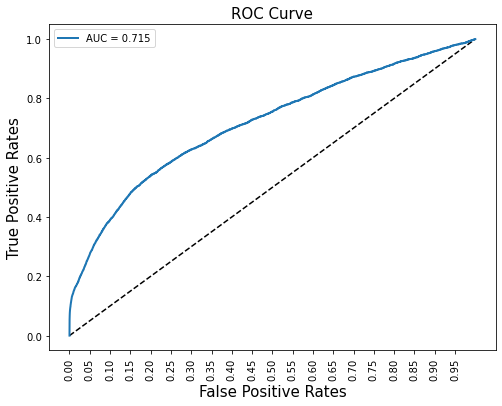

In [32]:
from sklearn.linear_model import LogisticRegression
model_1 = LogisticRegression(random_state=22)
model_1.fit(X_train, y_train)
model_evaluation(model_1,X_train,y_train)
plot_roc_curve(model_1,X_train,y_train)

[[22225    14]
 [  250    11]]

Accuracy: 0.9882666666666666
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22239
           1       0.44      0.04      0.08       261

    accuracy                           0.99     22500
   macro avg       0.71      0.52      0.54     22500
weighted avg       0.98      0.99      0.98     22500

ROC-AUC score: 0.7299047839570779
Best Threshold=0.015406


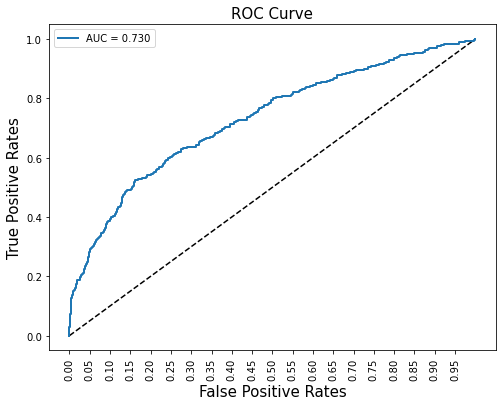

In [31]:
#from sklearn.linear_model import LogisticRegression
model_1 = LogisticRegression(random_state=42)
model_1.fit(X_train, y_train)
model_evaluation(model_1,X_test,y_test)
plot_roc_curve(model_1,X_test,y_test)

[[22025   214]
 [  205    56]]

Accuracy: 0.9813777777777778
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     22239
           1       0.21      0.21      0.21       261

    accuracy                           0.98     22500
   macro avg       0.60      0.60      0.60     22500
weighted avg       0.98      0.98      0.98     22500

ROC-AUC score: 0.6024683260689904
Best Threshold=1.000000


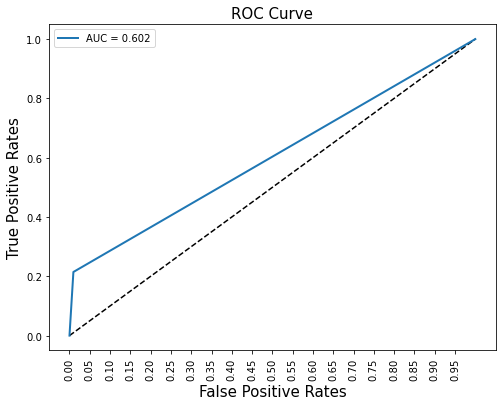

In [116]:
from sklearn.tree import DecisionTreeClassifier
model_2 = DecisionTreeClassifier(random_state=42,criterion='entropy')
model_2.fit(X_train, y_train)
model_evaluation(model_2,X_test,y_test)
plot_roc_curve(model_2,X_test,y_test)

[[22218    21]
 [  225    36]]

Accuracy: 0.9890666666666666
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22239
           1       0.63      0.14      0.23       261

    accuracy                           0.99     22500
   macro avg       0.81      0.57      0.61     22500
weighted avg       0.99      0.99      0.99     22500

ROC-AUC score: 0.831411508449052
Best Threshold=0.020000


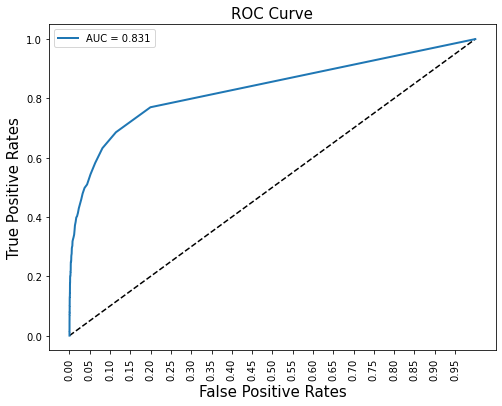

In [117]:
from sklearn.ensemble import RandomForestClassifier
model_3 = RandomForestClassifier(random_state=42,criterion='entropy')
model_3.fit(X_train, y_train)
model_evaluation(model_3,X_test,y_test)
plot_roc_curve(model_3,X_test,y_test)

[08:56:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[22212    27]
 [  205    56]]

Accuracy: 0.9896888888888888
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22239
           1       0.67      0.21      0.33       261

    accuracy                           0.99     22500
   macro avg       0.83      0.61      0.66     22500
weighted avg       0.99      0.99      0.99     22500

ROC-AUC score: 0.919902714829614
Best Threshold=0.009586


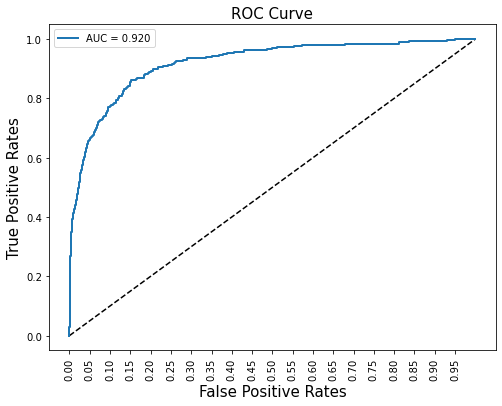

In [118]:
from xgboost import XGBClassifier
model_4 = XGBClassifier(random_state = 42)
model_4.fit(X_train, y_train)
model_evaluation(model_4,X_test,y_test)
plot_roc_curve(model_4,X_test,y_test)

In [119]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
Ras = RandomUnderSampler()
X_under, y_under = Ras.fit_resample(X_train,y_train)
print('Original dataset shape', Counter(y_train))
print('Undersample dataset shape', Counter(y_under))

Original dataset shape Counter({0: 422543, 1: 4956})
Undersample dataset shape Counter({0: 4956, 1: 4956})


[[15819  6420]
 [   84   177]]

Accuracy: 0.7109333333333333
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     22239
           1       0.03      0.68      0.05       261

    accuracy                           0.71     22500
   macro avg       0.51      0.69      0.44     22500
weighted avg       0.98      0.71      0.82     22500

ROC-AUC score: 0.7543990494073526
Best Threshold=0.513287


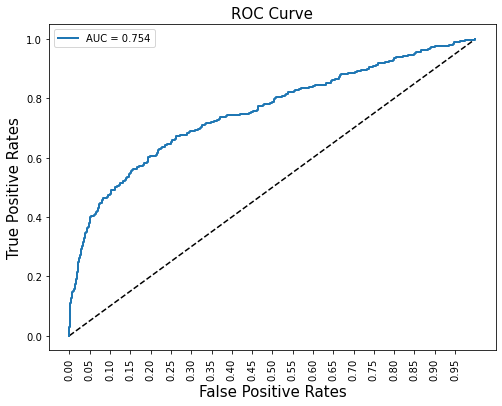

In [120]:
from sklearn.linear_model import LogisticRegression
model_5 = LogisticRegression(random_state=42)
model_5.fit(X_under, y_under)
model_evaluation(model_5,X_test,y_test)
plot_roc_curve(model_5,X_test,y_test)

[[17151  5088]
 [   61   200]]

Accuracy: 0.7711555555555556
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     22239
           1       0.04      0.77      0.07       261

    accuracy                           0.77     22500
   macro avg       0.52      0.77      0.47     22500
weighted avg       0.99      0.77      0.86     22500

ROC-AUC score: 0.7687481296448767
Best Threshold=1.000000


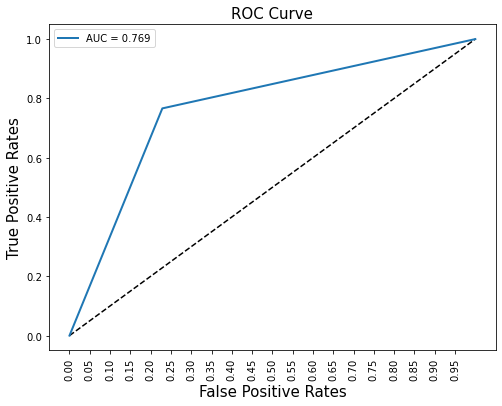

In [121]:
model_6 = DecisionTreeClassifier(random_state=42,criterion='entropy')
model_6.fit(X_under, y_under)
model_evaluation(model_6,X_test,y_test)
plot_roc_curve(model_6,X_test,y_test)

[[17700  4539]
 [   46   215]]

Accuracy: 0.7962222222222223
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     22239
           1       0.05      0.82      0.09       261

    accuracy                           0.80     22500
   macro avg       0.52      0.81      0.49     22500
weighted avg       0.99      0.80      0.88     22500

ROC-AUC score: 0.8900171749639366
Best Threshold=0.580000


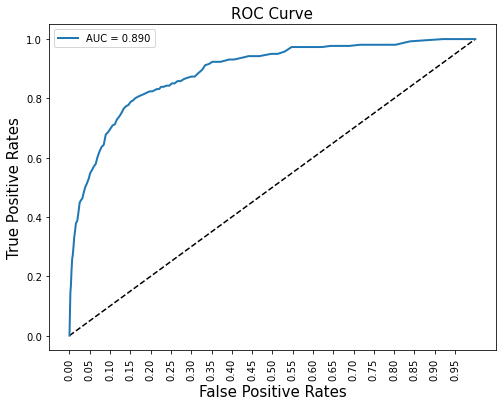

In [122]:
from sklearn.ensemble import RandomForestClassifier
model_7 = RandomForestClassifier(random_state=42,criterion='entropy')
model_7.fit(X_under, y_under)
model_evaluation(model_7,X_test,y_test)
plot_roc_curve(model_7,X_test,y_test)

[08:57:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[18347  3892]
 [   39   222]]

Accuracy: 0.8252888888888888
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     22239
           1       0.05      0.85      0.10       261

    accuracy                           0.83     22500
   macro avg       0.53      0.84      0.50     22500
weighted avg       0.99      0.83      0.89     22500

ROC-AUC score: 0.913134721216516
Best Threshold=0.450143


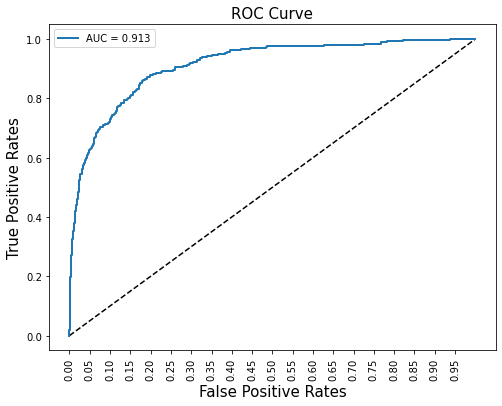

In [123]:
from xgboost import XGBClassifier
model_8 = XGBClassifier(random_state = 42)
model_8.fit(X_under, y_under)
model_evaluation(model_8,X_test,y_test)
plot_roc_curve(model_8,X_test,y_test)